# What is the binding profile of NFKB across gene models?

After processing RNA-seq data through alignment, gene/transcript
abundance estimation and differential expression analysis, we are left
with an unannotated list of differentially expressed genes. We may
want to know whether there is evidence to suggest that these genes are
regulated by a transcription factor of interest. We can answer this
using ChIP-seq data that we ourselves have generated or by using
public resources such as ENCODE.

For example, we have carried out an RNA-seq experiment in
lymphoblastoid cell lines (LCLs) looking at the effect of TNF-a
stimulation on gene expression. Using one of the many tools for
conducting differential expression analysis we have arrived at a set
of 133 genes that are up-regulated when LCLs are stimulated with
TNF-a.

We know that the main transcription factor that drives expression of
inflammatory genes using other immune stimulators is NFKB. We would
therefore like to answer the question:

Is there evidence to support a role for NFKB in the regulation of
genes regulated by TNF-a in LCLs?

ENCODE have produced many ChIP-seq data sets and by a stroke of luck
they have NFKB ChIP-seq data in TNF-a stimulated LCLs. In an
exploratory phase of the analysis, we would like to see what the
profile of NFKB binding is across genes i.e does it bind predominantly
at the TSS, exons or 3' UTR. We can do this fairly easily with a few
files and a few commands.

The input files that we require are:

* A :term:`gtf` file containing a complete set of known protein coding
  gene transcripts, which may be downloaded from ENSEMBL by typing::

    wget ftp://ftp.ensembl.org/pub/release-73/gtf/homo_sapiens/Homo_sapiens.GRCh37.73.gtf.gz -o logfile

* A file containing aligned NFKB ChIP-seq reads in :term:`bam` format,
  which is available via UCSC::

    wget -O nfkb.bam http://hgdownload-test.cse.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeSydhTfbs/wgEncodeSydhTfbsGm10847NfkbTnfaIggrabAlnRep1.bam -o logfile
    samtools index nfkb.bam

We can then take protein coding genes from ENSEMBL with an awk statement::

    wget -qO- ftp://ftp.ensembl.org/pub/release-72/gtf/homo_sapiens/Homo_sapiens.GRCh37.72.gtf.gz
    | gunzip 
    | awk '$2=="protein_coding" && $1=="chr19"' \
    | cgat gff2gff --method=sanitize=ucsc
    | gzip > protein_coding.chr19.gtf.gz

Here, we limit us to chr19 in order to speed up the profile computation.

With these data in place, we can use ``bam2geneprofile`` to assess the binding
profile of NFKB across gene models.

In [1]:
!cgat bam2geneprofile \
    --bam-file=nfkb.bam \
    --gtf-file=protein_coding.chr19.gtf.gz \
    --method=geneprofile \
    --output-filename-pattern=nfkb_profile_%s \
    > nfkb_profile.log

This statement will produce a matrix as an output file named
"nfkb_profile.geneprofile.matrix.tsv.gz". These data are amenable to
further manipulation and visualisation. For example, we can use R to
produce a profile plot over the gene model.

In [2]:
%load_ext rpy2.ipython
%R profile = read.csv("nfkb_profile_geneprofile.matrix.tsv.gz", header = T, stringsAsFactors = F, sep = "\t");
%R print(head(profile))

  bin   region region_bin none
1   0 upstream          0  846
2   1 upstream          1  867
3   2 upstream          2  865
4   3 upstream          3  877
5   4 upstream          4  904
6   5 upstream          5  904


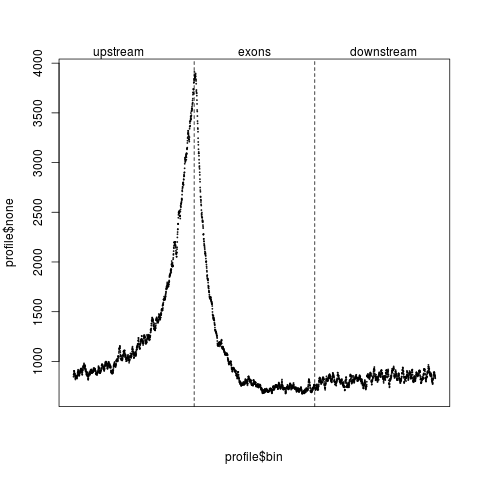

In [3]:
%%R
plot(profile$bin, profile$none, cex=0.2, xaxt = "none")
abline(v = c(1000, 2000), lty = 2);
mtext("upstream", adj = 0.1);
mtext("exons", adj = 0.5);
mtext("downstream", adj = 0.9);

This plot displays the predominance of NFKB binding at transcription
start sites of protein coding genes.